In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

In [2]:
df_base = pd.json_normalize(list(json.loads(line) for line in open("/tmp/stellarpunk_test.history", "r")))

In [3]:
df_base["eid"].unique()

array(['cdaa4af9-ad40-4eca-ba6d-84a43f60eef9',
       '910f6a51-6e2f-4a41-9a0e-2ebf716c951c'], dtype=object)

In [4]:
target_eid = df_base["eid"].unique()[1]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['910f6a51-6e2f-4a41-9a0e-2ebf716c951c'], dtype=object)

In [5]:
df_base

,index,eid,ts,loc,a,v,av,o.o,o.nnd,o.t_loc,o.t_v,o.cs,o.ct,o.ct_loc,o.ct_ts,o.ct_dv,o.cac,o.cbdr,o
0,2029,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.000000,"[5000.0, 0.0]",3.141593,"[0.0, 0.0]",0.000000,stellarpunk.orders.GoToLocation,10000.000000,"[-10000, 0]","[-1504.5791559668548, 0.0]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2030,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.016667,"[5000.0, 0.0]",3.141593,"[-4.166666666666667, 5.102694996447305e-16]",0.000000,stellarpunk.orders.GoToLocation,10000.000000,"[-10000, 0]","[-1504.5791559668548, 0.0]",False,cdaa4af9-ad40-4eca-ba6d-84a43f60eef9,"[-5000.0, 0.0]",0.016667,"[-0.0, -0.7779999999999999]",False,False,NaN
2,2031,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.033333,"[4999.930555555556, 8.504491660745507e-18]",3.141593,"[-4.166666666666667, -0.04166666666666615]",0.016667,stellarpunk.orders.GoToLocation,9999.861111,"[-10000, 0]","[-1501.942786104303, -8.515546023384794e-19]",False,cdaa4af9-ad40-4eca-ba6d-84a43f60eef9,"[-4999.930555555556, 0.0]",0.033333,"[-0.0, -0.5800888345671478]",False,False,NaN
3,2032,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.050000,"[4999.861111111111, -0.0006944444444444273]",3.141870,"[-4.166666666666667, -0.08333333333333282]",0.033333,stellarpunk.orders.GoToLocation,9999.722222,"[-10000, 0]","[-1499.3127377157205, 6.941326946155444e-05]",False,cdaa4af9-ad40-4eca-ba6d-84a43f60eef9,"[-4999.861111111111, 0.0006944444444444444]",0.050000,"[-1.760807505301662e-08, -0.3803308995073839]",False,False,NaN
4,2033,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.066667,"[4999.791666666667, -0.0020833333333333077]",3.142426,"[-4.166666668595697, -0.12499999999999944]",0.050000,stellarpunk.orders.GoToLocation,9999.583333,"[-10000, 0]","[-1496.688998457854, 0.00020787635917968799]",False,cdaa4af9-ad40-4eca-ba6d-84a43f60eef9,"[-4999.791666666667, 0.002083333333333333]",0.066667,"[-2.510121002179841e-08, -0.18072620204491924]",False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024,4053,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,33.733333,"[-9071.995488394286, -21.386686690838605]",-0.023356,"[-13.286184603997537, 0.3061919030443963]",0.000000,stellarpunk.orders.GoToLocation,18144.041395,"[-10000, 0]","[0.0, 0.0]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025,4054,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,33.750000,"[-9072.216924804354, -21.38158349245453]",-0.023356,"[-9.120623981955283, 0.21019286553845995]",0.000000,stellarpunk.orders.GoToLocation,18144.484242,"[-10000, 0]","[0.0, 0.0]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026,4055,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,33.766667,"[-9072.368935204053, -21.37808027802889]",-0.023356,"[-4.95506335991303, 0.11419382803252727]",0.000000,stellarpunk.orders.GoToLocation,18144.788246,"[-10000, 0]","[0.0, 0.0]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2027,4056,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,33.783333,"[-9072.451519593385, -21.37617704756168]",-0.023356,"[-0.7895027378707766, 0.01819479052659459]",0.000000,stellarpunk.orders.GoToLocation,18144.953405,"[-10000, 0]","[0.0, 0.0]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctdv, o_tloc, o_tv, angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array

In [7]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o_ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)

In [8]:
df

,index,eid,ts,loc,a,v,av,o.o,o.nnd,o.t_loc,...,o.t_loc.x,o.t_loc.y,o.t_v.x,o.t_v.y,angle.x,angle.y,speed,o_ct_dist,o_t_dist,o_t_speed
0,2029,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.000000,"[5000.0, 0.0]",3.141593,"[0.0, 0.0]",0.000000,stellarpunk.orders.GoToLocation,10000.000000,"[-10000, 0]",...,-10000.0,0.0,-1504.579156,0.000000e+00,-100.000000,1.224647e-14,0.000000e+00,NaN,15000.000000,1504.579156
1,2030,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.016667,"[5000.0, 0.0]",3.141593,"[-4.166666666666667, 5.102694996447305e-16]",0.000000,stellarpunk.orders.GoToLocation,10000.000000,"[-10000, 0]",...,-10000.0,0.0,-1504.579156,0.000000e+00,-100.000000,1.224647e-14,4.166667e+00,10000.000000,15000.000000,1504.579156
2,2031,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.033333,"[4999.930555555556, 8.504491660745507e-18]",3.141593,"[-4.166666666666667, -0.04166666666666615]",0.016667,stellarpunk.orders.GoToLocation,9999.861111,"[-10000, 0]",...,-10000.0,0.0,-1501.942786,-8.515546e-19,-100.000000,1.224647e-14,4.166875e+00,9999.861111,14999.930556,1501.942786
3,2032,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.050000,"[4999.861111111111, -0.0006944444444444273]",3.141870,"[-4.166666666666667, -0.08333333333333282]",0.033333,stellarpunk.orders.GoToLocation,9999.722222,"[-10000, 0]",...,-10000.0,0.0,-1499.312738,6.941327e-05,-99.999996,-2.777778e-02,4.167500e+00,9999.722222,14999.861111,1499.312738
4,2033,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.066667,"[4999.791666666667, -0.0020833333333333077]",3.142426,"[-4.166666668595697, -0.12499999999999944]",0.050000,stellarpunk.orders.GoToLocation,9999.583333,"[-10000, 0]",...,-10000.0,0.0,-1496.688998,2.078764e-04,-99.999965,-8.333332e-02,4.168541e+00,9999.583333,14999.791667,1496.688998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024,4053,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,33.733333,"[-9071.995488394286, -21.386686690838605]",-0.023356,"[-13.286184603997537, 0.3061919030443963]",0.000000,stellarpunk.orders.GoToLocation,18144.041395,"[-10000, 0]",...,-10000.0,0.0,0.000000,0.000000e+00,99.972726,-2.335409e+00,1.328971e+01,NaN,928.250916,0.000000
2025,4054,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,33.750000,"[-9072.216924804354, -21.38158349245453]",-0.023356,"[-9.120623981955283, 0.21019286553845995]",0.000000,stellarpunk.orders.GoToLocation,18144.484242,"[-10000, 0]",...,-10000.0,0.0,0.000000,0.000000e+00,99.972726,-2.335409e+00,9.123046e+00,NaN,928.029421,0.000000
2026,4055,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,33.766667,"[-9072.368935204053, -21.37808027802889]",-0.023356,"[-4.95506335991303, 0.11419382803252727]",0.000000,stellarpunk.orders.GoToLocation,18144.788246,"[-10000, 0]",...,-10000.0,0.0,0.000000,0.000000e+00,99.972726,-2.335409e+00,4.956379e+00,NaN,927.877371,0.000000
2027,4056,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,33.783333,"[-9072.451519593385, -21.37617704756168]",-0.023356,"[-0.7895027378707766, 0.01819479052659459]",0.000000,stellarpunk.orders.GoToLocation,18144.953405,"[-10000, 0]",...,-10000.0,0.0,0.000000,0.000000e+00,99.972726,-2.335409e+00,7.897124e-01,NaN,927.794764,0.000000


In [9]:
df.head(50)

,index,eid,ts,loc,a,v,av,o.o,o.nnd,o.t_loc,...,o.t_loc.x,o.t_loc.y,o.t_v.x,o.t_v.y,angle.x,angle.y,speed,o_ct_dist,o_t_dist,o_t_speed
0,2029,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.000000,"[5000.0, 0.0]",3.141593,"[0.0, 0.0]",0.000000,stellarpunk.orders.GoToLocation,10000.000000,"[-10000, 0]",...,-10000.0,0.0,-1504.579156,0.000000e+00,-100.000000,1.224647e-14,0.000000,NaN,15000.000000,1504.579156
1,2030,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.016667,"[5000.0, 0.0]",3.141593,"[-4.166666666666667, 5.102694996447305e-16]",0.000000,stellarpunk.orders.GoToLocation,10000.000000,"[-10000, 0]",...,-10000.0,0.0,-1504.579156,0.000000e+00,-100.000000,1.224647e-14,4.166667,10000.000000,15000.000000,1504.579156
2,2031,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.033333,"[4999.930555555556, 8.504491660745507e-18]",3.141593,"[-4.166666666666667, -0.04166666666666615]",0.016667,stellarpunk.orders.GoToLocation,9999.861111,"[-10000, 0]",...,-10000.0,0.0,-1501.942786,-8.515546e-19,-100.000000,1.224647e-14,4.166875,9999.861111,14999.930556,1501.942786
3,2032,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.050000,"[4999.861111111111, -0.0006944444444444273]",3.141870,"[-4.166666666666667, -0.08333333333333282]",0.033333,stellarpunk.orders.GoToLocation,9999.722222,"[-10000, 0]",...,-10000.0,0.0,-1499.312738,6.941327e-05,-99.999996,-2.777778e-02,4.167500,9999.722222,14999.861111,1499.312738
4,2033,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.066667,"[4999.791666666667, -0.0020833333333333077]",3.142426,"[-4.166666668595697, -0.12499999999999944]",0.050000,stellarpunk.orders.GoToLocation,9999.583333,"[-10000, 0]",...,-10000.0,0.0,-1496.688998,2.078764e-04,-99.999965,-8.333332e-02,4.168541,9999.583333,14999.791667,1496.688998
5,2034,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.083333,"[4999.722222222191, -0.004166666666666632]",3.143259,"[-4.166666674382815, -0.1666666666666657]",0.066667,stellarpunk.orders.GoToLocation,9999.444444,"[-10000, 0]",...,-10000.0,0.0,-1494.071556,4.150276e-04,-99.999861,-1.666666e-01,4.169999,NaN,14999.722222,1494.071556
6,2035,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.100000,"[4999.652777777617, -0.006944444444444394]",3.144370,"[-8.333333314849597, -0.16619940615454987]",0.050000,stellarpunk.orders.GoToLocation,9999.305556,"[-10000, 0]",...,-10000.0,0.0,-1496.850346,6.930023e-04,-99.999614,-2.777774e-01,8.334990,9999.305556,14999.652778,1496.850346
7,2036,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.116667,"[4999.513888889036, -0.009714434547020225]",3.145204,"[-8.333333334140168, -0.20786607282121206]",0.066667,stellarpunk.orders.GoToLocation,9999.027778,"[-10000, 0]",...,-10000.0,0.0,-1494.227468,9.677364e-04,-99.999348,-3.611103e-01,8.335925,9999.027778,14999.513889,1494.227468
8,2037,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.133333,"[4999.375000000134, -0.013178869094040426]",3.146315,"[-8.333333361125582, -0.24953273948786997]",0.083333,stellarpunk.orders.GoToLocation,9998.750000,"[-10000, 0]",...,-10000.0,0.0,-1491.610883,1.310571e-03,-99.998885,-4.722205e-01,8.337069,9998.750000,14999.375000,1491.610883
9,2038,910f6a51-6e2f-4a41-9a0e-2ebf716c951c,0.150000,"[4999.236111110781, -0.017337748085504926]",3.147704,"[-8.333333397735078, -0.29119940615452056]",0.100000,stellarpunk.orders.GoToLocation,9998.472222,"[-10000, 0]",...,-10000.0,0.0,-1489.000577,1.721149e-03,-99.998133,-6.111073e-01,8.338420,9998.472222,14999.236111,1489.000577


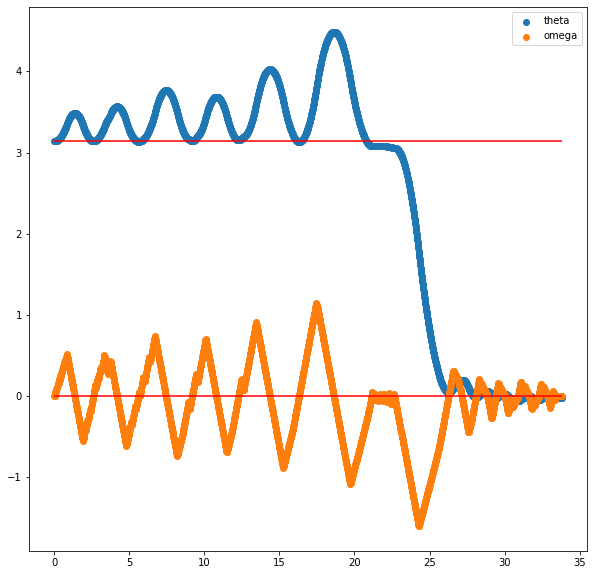

In [10]:
plt.figure(figsize=(10, 10))
plt.scatter(df["ts"], df["a"], label="theta")
plt.scatter(df["ts"], df["av"], label="omega")
plt.hlines(np.pi, df["ts"].min(), df["ts"].max(), color="red")
plt.hlines(0, df["ts"].min(), df["ts"].max(), color="red")
plt.legend()


In [11]:
df[(df["ts"] > 3.7) & (df["ts"] < 4)]["a"].describe()

count    18.000000
mean      3.513538
std       0.028821
min       3.462109
25%       3.491882
50%       3.517211
75%       3.537540
max       3.552869
Name: a, dtype: float64

In [12]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=33.799999999999365, continuous_update=False, description='max_time', m…

<function __main__.plot_location_chart(max_time)>

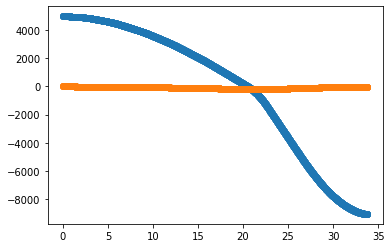

In [13]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])

(0.0, 1610.235585729574)

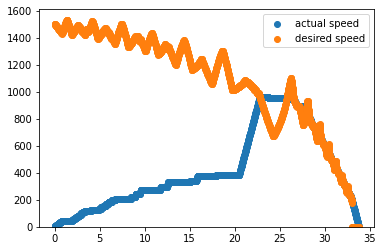

In [14]:
plt.scatter(df["ts"], df["speed"], label="actual speed")
plt.scatter(df["ts"], df["o_t_speed"], label="desired speed")
plt.legend()
plt.ylim(0)


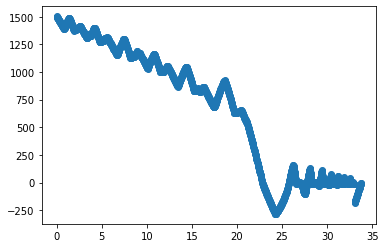

In [15]:
plt.scatter(df["ts"], df["o_t_speed"] - df["speed"])

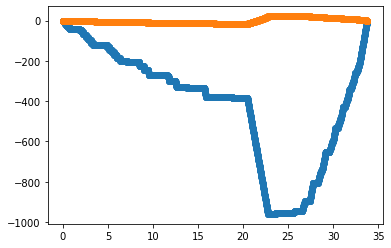

In [16]:
plt.scatter(df["ts"], df["v.x"])
plt.scatter(df["ts"], df["v.y"])

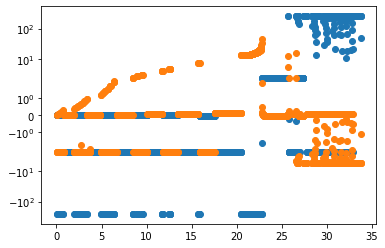

In [17]:
#plt.scatter(df["ts"], (df["v.x"] - df["v.x"].shift(-1)))#/(df["ts"]-df["ts"].shift(-1)))
plt.scatter(df["ts"], (df["v.x"].shift(1) - df["v.x"]) / (df["ts"].shift(1) - df["ts"]))
plt.scatter(df["ts"], (df["v.y"].shift(1) - df["v.y"]) / (df["ts"].shift(1) - df["ts"]))
plt.yscale("symlog")

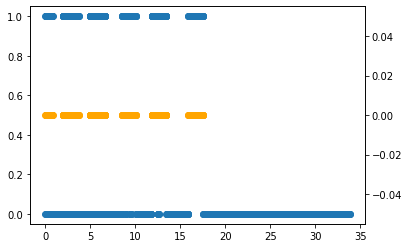

In [18]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")

#ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

In [19]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.legend()

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=33.799999…

<function __main__.plot_collision_info(hist_length, max_time)>

(0.0, 10485.0)

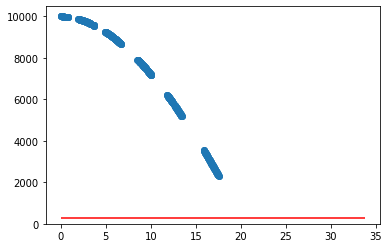

In [20]:
plt.scatter(df["ts"], df["o_ct_dist"])
plt.hlines(300, df["ts"].min(), df["ts"].max(), color="red")
plt.ylim(0)

In [21]:
if np.any(~df["o.ct"].isna()):
    df.groupby("o.ct")["ts"].describe()

In [22]:
if np.any(~df["o.ct"].isna()):
    df.groupby("o.ct")["o_ct_dist"].describe()

(927.7947641853712, 927.7947641853712)

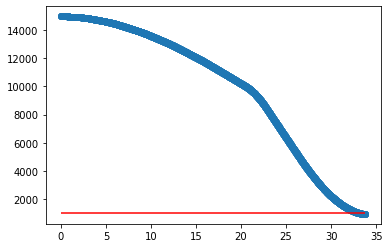

In [23]:
plt.scatter(df["ts"], df["o_t_dist"])
plt.hlines(1000, df["ts"].min(), df["ts"].max(), color="red")
df["o_t_dist"].min(),df[df["ts"] > df["ts"].max()-1]["o_t_dist"].min()

In [24]:
df[(df["ts"] >11.3)&(df["ts"]<11.4)]["o_t_dist"]

678    13244.185476
679    13239.655689
680    13235.125211
681    13230.594041
682    13226.062181
683    13221.529628
Name: o_t_dist, dtype: float64

In [25]:
if np.any(~df["o.t_loc"].isna()):
    df.groupby(["o.t_loc.x", "o.t_loc.y"])["ts"].describe().sort_values(["min"])

In [26]:
df.groupby(["o.t_loc.x", "o.t_loc.y"])["o_t_dist"].describe()

,,count,mean,std,min,25%,50%,75%,max
o.t_loc.x,o.t_loc.y,,,,,,,,
-10000.0,0.0,2028.0,9882.718593,4662.910527,927.794764,6032.836046,11388.398854,13974.572294,15000.0


In [27]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::20]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], label="v")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(df["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    plt.axis('equal')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=33.799999…

<function __main__.plot_collision_chart(hist_length=33.799999999999365, max_time=33.799999999999365)>

In [28]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="ship")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=33.799999…

<function __main__.plot_collision_chart(hist_length=33.799999999999365, max_time=33.799999999999365)>

In [29]:
df["v.x"].describe()

count    2029.000000
mean     -416.139912
std       288.149345
min      -959.656532
25%      -614.092303
50%      -335.273548
75%      -204.212379
max         0.000000
Name: v.x, dtype: float64

In [30]:
df["v.y"].describe()

count    2029.000000
mean       -0.632111
std        12.855855
min       -16.078368
25%       -11.344405
50%        -4.713694
75%        11.299933
max        21.669538
Name: v.y, dtype: float64

# 